# 3D-BPP

## Pre-requisites

In [4]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import sys
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

sys.path.append('src/')
import config, dataset, main, utils, bins


<IPython.core.display.Javascript object>

In [5]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [6]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Pallets and containers

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

## Dataset

### Products

In [7]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


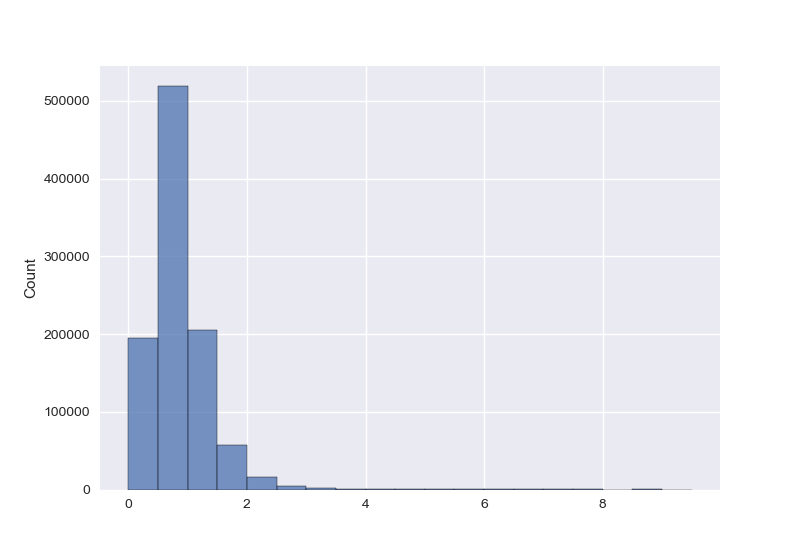

<IPython.core.display.Javascript object>

In [8]:
plt.figure()
sns.histplot(
    product_dataset.products.depth / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


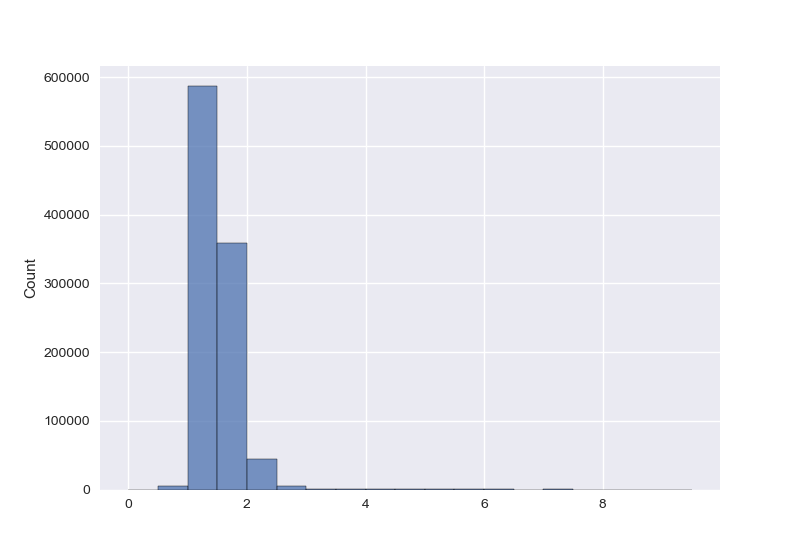

<IPython.core.display.Javascript object>

In [9]:
plt.figure()
sns.histplot(
    product_dataset.products.height / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


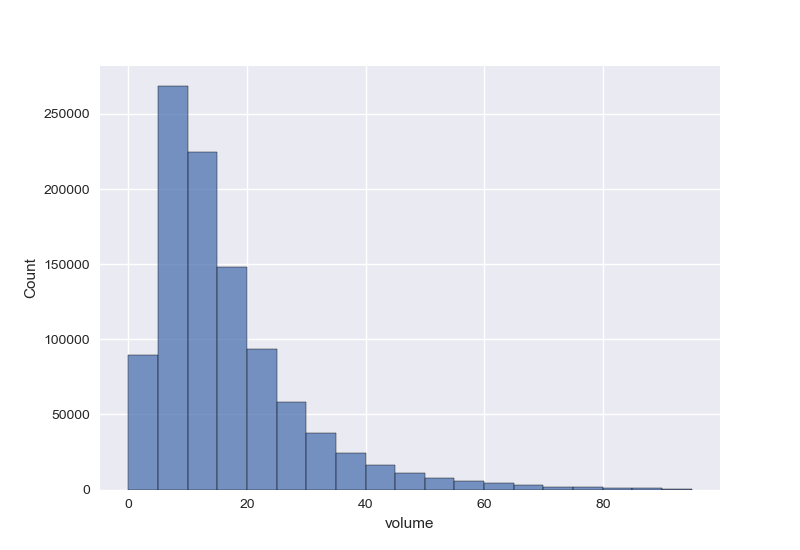

<IPython.core.display.Javascript object>

In [10]:
plt.figure()
sns.histplot(product_dataset.products.volume / 1e6, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


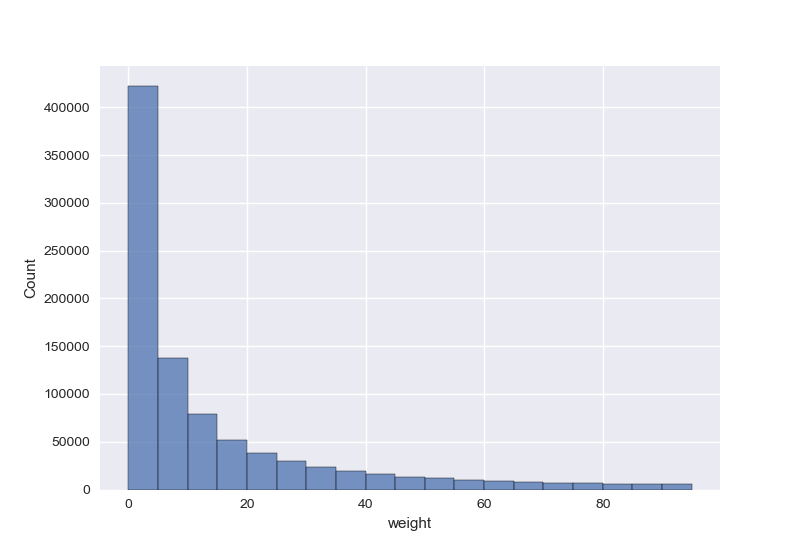

<IPython.core.display.Javascript object>

In [11]:
plt.figure()
sns.histplot(product_dataset.products.weight, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


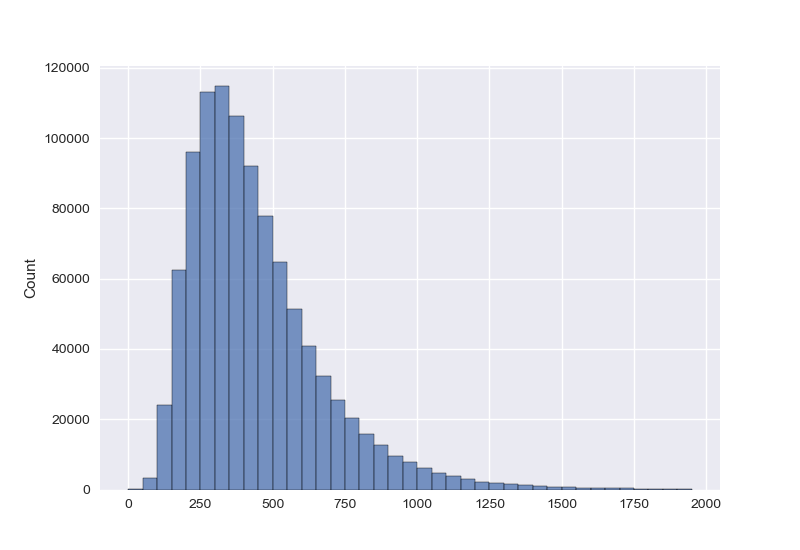

<IPython.core.display.Javascript object>

In [12]:
plt.figure()
sns.histplot(
    product_dataset.products.width * product_dataset.products.depth / 100,
    bins=np.arange(0, 2000, 50),
)
plt.show()

### Order

In [13]:
ordered_products = 50
order = product_dataset.get_order(ordered_products)
# order = product_dataset.get_dummy_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,121958,193,221,371,2,15824263
1,671155,236,142,437,58,14644744
2,131932,228,139,254,26,8049768
3,365838,267,131,322,11,11262594
4,259178,253,191,580,68,28027340


<IPython.core.display.Javascript object>

## Martello's lower bounds

In [68]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [69]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [70]:
utils.get_l2_lb(order, config.PALLET_DIMS)

2500it [00:10, 231.49it/s]
2450it [00:10, 233.15it/s]
2450it [00:10, 234.02it/s]


(1.0, 1.0, 1.0, 1.0)

<IPython.core.display.Javascript object>

## Baseline

In [11]:
bl_layer_pool = main.baseline_procedure(order)
bl_layer_pool.to_dataframe()

Generating vertical superitems: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Items not covered: 0/10


,item,x,y,z,width,depth,height,layer
0,0,353,0,0,343,263,411,0
1,1,0,0,0,294,136,440,0
2,2,0,136,0,180,57,234,0
3,3,0,193,0,176,100,225,0
4,4,180,136,0,173,179,248,0
5,5,0,315,0,202,210,349,0
6,6,0,525,0,366,256,654,0
7,7,366,263,0,277,192,416,0
8,8,643,263,0,286,162,450,0
9,9,929,0,0,249,237,318,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


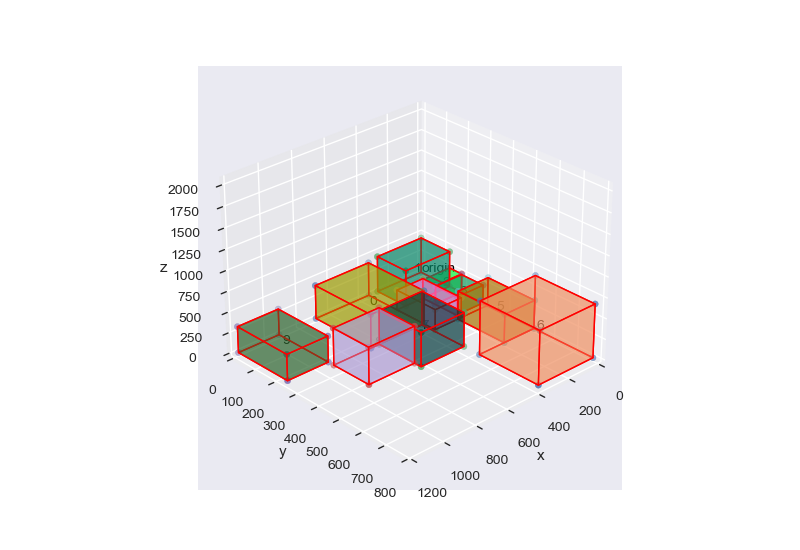

<IPython.core.display.Javascript object>

In [12]:
bl_bin_pool = bins.BinPool(bl_layer_pool, config.PALLET_DIMS)
bl_bin_pool.plot()

## Maxrects

In [15]:
mr_layer_pool = main.maxrects_procedure(order)
mr_layer_pool.to_dataframe()

2021-07-30 15:39:48.920 | INFO     | main:maxrects_procedure:132 - Maxrects iteration 1/1
Generating vertical superitems: 100%|██████████████████████████████████████████████████████████████| 14/14 [00:00<?, ?it/s]
2021-07-30 15:39:48.964 | INFO     | main:maxrects_warm_start:42 - Computing warm start layers
2021-07-30 15:39:48.989 | INFO     | main:maxrects_warm_start:55 - Identified 0 layers in warm start
2021-07-30 15:39:48.995 | INFO     | main:maxrects_procedure:160 - Items not covered: 50/50


Generated 0
Density 0
Coverage 0
Duplicates 0
Empty 0


""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


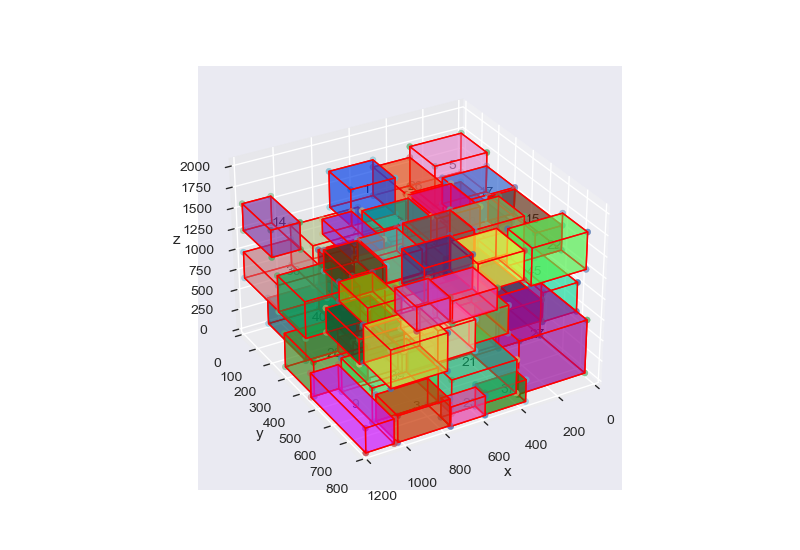

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [16]:
mr_bin_pool = bins.BinPool(mr_layer_pool, config.PALLET_DIMS)
mr_bin_pool.plot()

## Column generation

2021-07-30 15:56:35.415 | INFO     | main:column_generation_procedure:209 - Processing height group 1/1
2021-07-30 15:56:35.416 | INFO     | main:maxrects_warm_start:42 - Computing warm start layers
2021-07-30 15:56:35.420 | INFO     | main:maxrects_warm_start:55 - Processing height group 1/1
2021-07-30 15:56:35.435 | INFO     | main:maxrects_warm_start:58 - Identified 53 layers in warm start
2021-07-30 15:56:35.531 | INFO     | column_generation:main_problem:110 - RMP: solved with 53 variables, 50 constraints, in 46 iterations


Iteration 1/100
Solving RMP...
RMP objective: 1715.0
Duals: [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 305.   0.   0.   0.   0.   0.   9. 411.   0. 234.   0.   0.   0.   0.
   0.   0. 158.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 422.
 176.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 0.089
Alphas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
Solving SP (no placement)...


2021-07-30 15:56:35.807 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 50
2021-07-30 15:56:35.807 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.0021186440677966097 reward about selecting superitems with zero dual
2021-07-30 15:56:35.841 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 1 iterations


SP no placement time: 0.277
Reduced cost: -1715.0402542372879
Solving SP (with placement)...


2021-07-30 15:56:40.974 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 25
2021-07-30 15:56:40.975 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.0021186440677966097 reward about selecting superitems with zero dual
2021-07-30 15:56:40.978 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations


SP placement time: 5.016640732
FEASIBILITY:  25
Solving SP (no placement)...
SP no placement time: 0.008
Reduced cost: -1715.03813559322
Solving SP (with placement)...


2021-07-30 15:56:46.028 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 24
2021-07-30 15:56:46.028 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.0021186440677966097 reward about selecting superitems with zero dual
2021-07-30 15:56:46.031 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations


SP placement time: 5.030935028
FEASIBILITY:  24
Solving SP (no placement)...
SP no placement time: 0.007
Reduced cost: -1715.036016949152
Solving SP (with placement)...


2021-07-30 15:56:51.078 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 23
2021-07-30 15:56:51.079 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.0021186440677966097 reward about selecting superitems with zero dual
2021-07-30 15:56:51.081 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations


SP placement time: 5.028980837000001
FEASIBILITY:  23
Solving SP (no placement)...
SP no placement time: 0.007
Reduced cost: -1715.0338983050844
Solving SP (with placement)...
SP placement time: 0.23823675900000002
New layer: Num selected Items: 23 / 50


<IPython.core.display.Javascript object>


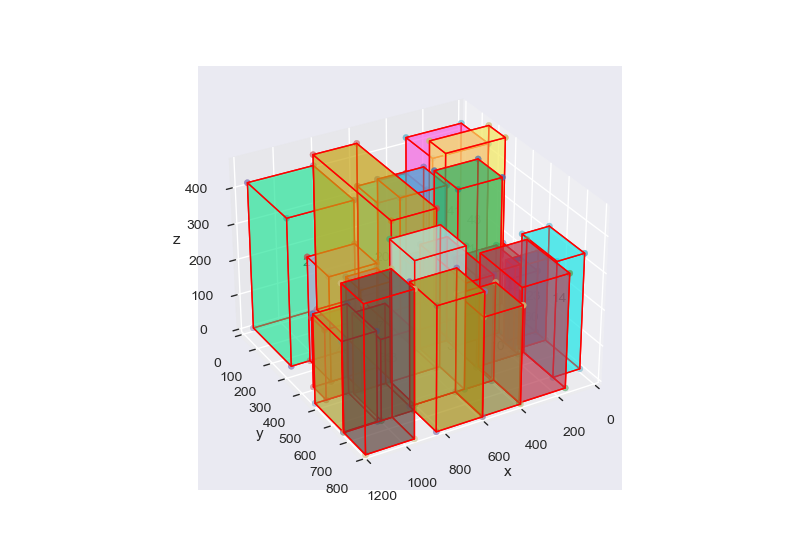

2021-07-30 15:56:51.425 | INFO     | column_generation:main_problem:110 - RMP: solved with 54 variables, 50 constraints, in 48 iterations
2021-07-30 15:56:51.431 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 50
2021-07-30 15:56:51.432 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.0021929824561403508 reward about selecting superitems with zero dual
2021-07-30 15:56:51.435 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 1 iterations


Iteration 2/100
Solving RMP...
RMP objective: 1715.0
Duals: [  0.   0.   0.   0.   0.   0.   0.   0.   0. 248.   0.   0. 323. 132.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 349.   0.
   0.   0.   0.   0.   0.   0.   0.   0. 406.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0. 257.]
RMP time: 0.002
Alphas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]
Solving SP (no placement)...
SP no placement time: 0.007
Reduced cost: -1715.050438596491
Solving SP (with placement)...


2021-07-30 15:56:56.482 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 28
2021-07-30 15:56:56.482 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.0021929824561403508 reward about selecting superitems with zero dual
2021-07-30 15:56:56.485 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations


SP placement time: 5.028387568
FEASIBILITY:  28
Solving SP (no placement)...
SP no placement time: 0.006
Reduced cost: -1715.046052631579
Solving SP (with placement)...


2021-07-30 15:57:01.533 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 26
2021-07-30 15:57:01.534 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.0021929824561403508 reward about selecting superitems with zero dual
2021-07-30 15:57:01.537 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations


SP placement time: 5.02716031
FEASIBILITY:  26
Solving SP (no placement)...
SP no placement time: 0.007
Reduced cost: -1715.0438596491226
Solving SP (with placement)...


2021-07-30 15:57:06.579 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 25
2021-07-30 15:57:06.580 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.0021929824561403508 reward about selecting superitems with zero dual
2021-07-30 15:57:06.582 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations


SP placement time: 5.0230739
FEASIBILITY:  25
Solving SP (no placement)...
SP no placement time: 0.006
Reduced cost: -1715.0416666666665
Solving SP (with placement)...
SP placement time: 0.33120367500000003
New layer: Num selected Items: 25 / 50


<IPython.core.display.Javascript object>


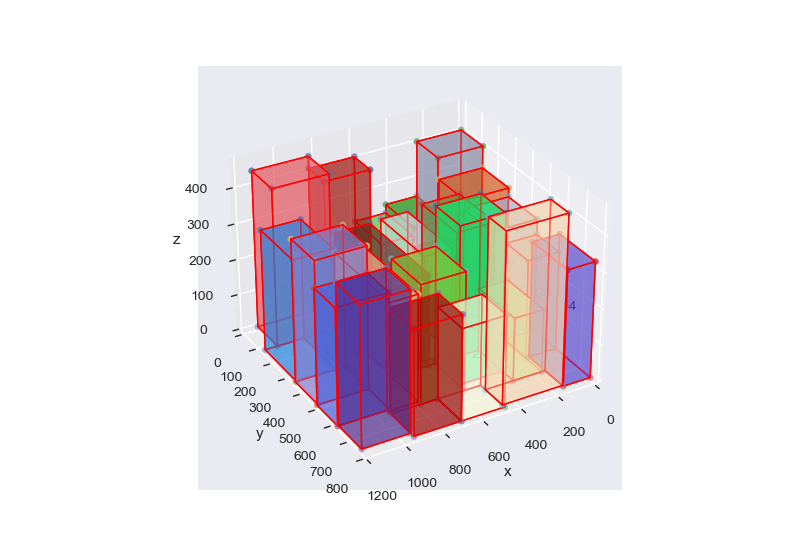

2021-07-30 15:57:07.005 | INFO     | column_generation:main_problem:110 - RMP: solved with 55 variables, 50 constraints, in 51 iterations
2021-07-30 15:57:07.010 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 50
2021-07-30 15:57:07.012 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.0023752969121140144 reward about selecting superitems with zero dual
2021-07-30 15:57:07.015 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 1 iterations


Iteration 3/100
Solving RMP...
RMP objective: 1715.0
Duals: [371.   0.   0.   0.   0. 204. 182.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 277.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 209. 195. 277.   0.   0.]
RMP time: 0.002
Alphas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 0.008
Reduced cost: -1715.0498812351545
Solving SP (with placement)...


2021-07-30 15:57:12.059 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 27
2021-07-30 15:57:12.060 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.0023752969121140144 reward about selecting superitems with zero dual
2021-07-30 15:57:12.062 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations


SP placement time: 5.0250546620000005
FEASIBILITY:  27
Solving SP (no placement)...
SP no placement time: 0.006
Reduced cost: -1715.0475059382427
Solving SP (with placement)...


2021-07-30 15:57:17.097 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 26
2021-07-30 15:57:17.098 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.0023752969121140144 reward about selecting superitems with zero dual
2021-07-30 15:57:17.100 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations


SP placement time: 5.017189312
FEASIBILITY:  26
Solving SP (no placement)...
SP no placement time: 0.006
Reduced cost: -1715.0451306413306
Solving SP (with placement)...


2021-07-30 15:57:22.160 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 25
2021-07-30 15:57:22.161 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.0023752969121140144 reward about selecting superitems with zero dual
2021-07-30 15:57:22.164 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations


SP placement time: 5.038841206000001
FEASIBILITY:  25
Solving SP (no placement)...
SP no placement time: 0.009
Reduced cost: -1715.0427553444183
Solving SP (with placement)...


2021-07-30 15:57:27.205 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 24
2021-07-30 15:57:27.205 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.0023752969121140144 reward about selecting superitems with zero dual
2021-07-30 15:57:27.208 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 6 iterations


SP placement time: 5.020594529
FEASIBILITY:  24
Solving SP (no placement)...
SP no placement time: 0.006
Reduced cost: -1715.040380047506
Solving SP (with placement)...
SP placement time: 0.316812827
New layer: Num selected Items: 24 / 50


<IPython.core.display.Javascript object>


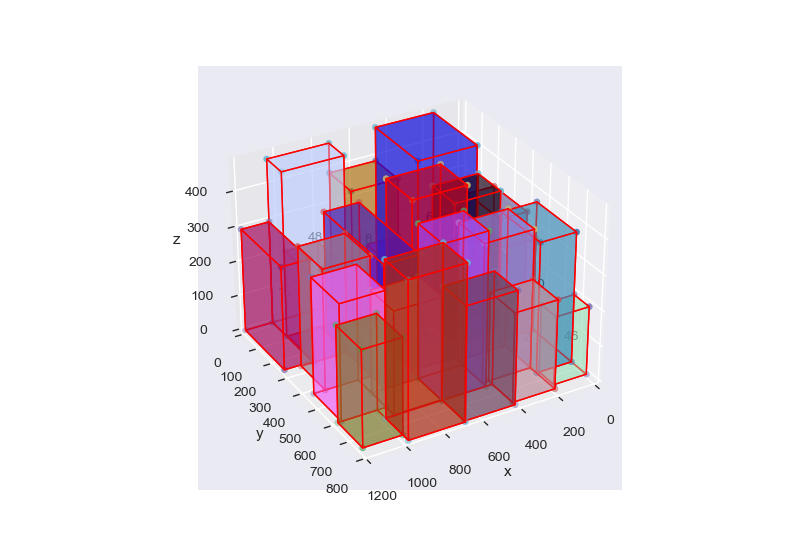

2021-07-30 15:57:27.673 | INFO     | column_generation:main_problem:110 - RMP: solved with 56 variables, 50 constraints, in 52 iterations
2021-07-30 15:57:27.679 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 50
2021-07-30 15:57:27.680 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.001976284584980237 reward about selecting superitems with zero dual
2021-07-30 15:57:27.682 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 1 iterations


Iteration 4/100
Solving RMP...
RMP objective: 1715.0
Duals: [  0.   0.   0.   0.   0.   9.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 123.   0.  93. 441.   0.   0.   0.   0.   0. 349.   0.
   0.   0.  31.   0.   0. 456.   0.   0.   0.   0.   0. 213.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 0.002
Alphas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 0.006
Reduced cost: -1715.0335968379447
Solving SP (with placement)...


2021-07-30 15:57:32.734 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 24
2021-07-30 15:57:32.736 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.001976284584980237 reward about selecting superitems with zero dual
2021-07-30 15:57:32.738 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 3 iterations


SP placement time: 5.032062791
FEASIBILITY:  24
Solving SP (no placement)...
SP no placement time: 0.009
Reduced cost: -1715.0316205533595
Solving SP (with placement)...


2021-07-30 15:57:37.794 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 23
2021-07-30 15:57:37.795 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.001976284584980237 reward about selecting superitems with zero dual
2021-07-30 15:57:37.798 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations


SP placement time: 5.029456229
FEASIBILITY:  23
Solving SP (no placement)...
SP no placement time: 0.008
Reduced cost: -1715.0296442687745
Solving SP (with placement)...


2021-07-30 15:57:42.833 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 22
2021-07-30 15:57:42.834 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.001976284584980237 reward about selecting superitems with zero dual
2021-07-30 15:57:42.836 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 5 iterations


SP placement time: 5.0174349000000005
FEASIBILITY:  22
Solving SP (no placement)...
SP no placement time: 0.006
Reduced cost: -1715.0276679841895
Solving SP (with placement)...
SP placement time: 3.1399743730000003
New layer: Num selected Items: 22 / 50


<IPython.core.display.Javascript object>


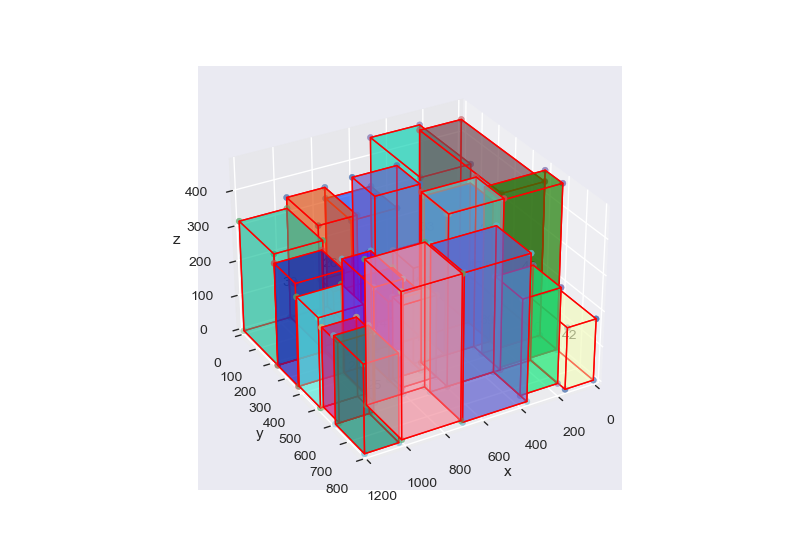

2021-07-30 15:57:46.072 | INFO     | column_generation:main_problem:110 - RMP: solved with 57 variables, 50 constraints, in 52 iterations
2021-07-30 15:57:46.078 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 50
2021-07-30 15:57:46.079 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.00186219739292365 reward about selecting superitems with zero dual
2021-07-30 15:57:46.083 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 1 iterations


Iteration 5/100
Solving RMP...
RMP objective: 1715.0
Duals: [  0.   0.   0.   0.   0.   9.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 123.   0.   0.   0.   0.   0.   0.   0.   0. 349. 329.
   0.  93.   0.   0.   0.   0.   0. 487.   0.   0.   0.   0. 325.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 0.003
Alphas: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 0.009
Reduced cost: -1715.0372439478585
Solving SP (with placement)...


2021-07-30 15:57:51.129 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 26
2021-07-30 15:57:51.130 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.00186219739292365 reward about selecting superitems with zero dual
2021-07-30 15:57:51.133 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations


SP placement time: 5.024202229
FEASIBILITY:  26
Solving SP (no placement)...
SP no placement time: 0.009
Reduced cost: -1715.0353817504656
Solving SP (with placement)...


2021-07-30 15:57:56.184 | INFO     | column_generation:pricing_problem_no_placement:166 - SP-NP: setting number of selected items <= 25
2021-07-30 15:57:56.185 | INFO     | column_generation:pricing_problem_no_placement:176 - SP-NP: 0.00186219739292365 reward about selecting superitems with zero dual
2021-07-30 15:57:56.188 | INFO     | column_generation:pricing_problem_no_placement:198 - SP-NP: solved with 51 variables, 52 constraints, in 4 iterations


SP placement time: 5.030434782
FEASIBILITY:  25
Solving SP (no placement)...
SP no placement time: 0.009
Reduced cost: -1715.0335195530727
Solving SP (with placement)...


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [20]:
cg_layer_pool, cg_bins_lbs = main.column_generation_procedure(
    order, use_height_groups=False
)
cg_layer_pool.to_dataframe()

<IPython.core.display.Javascript object>


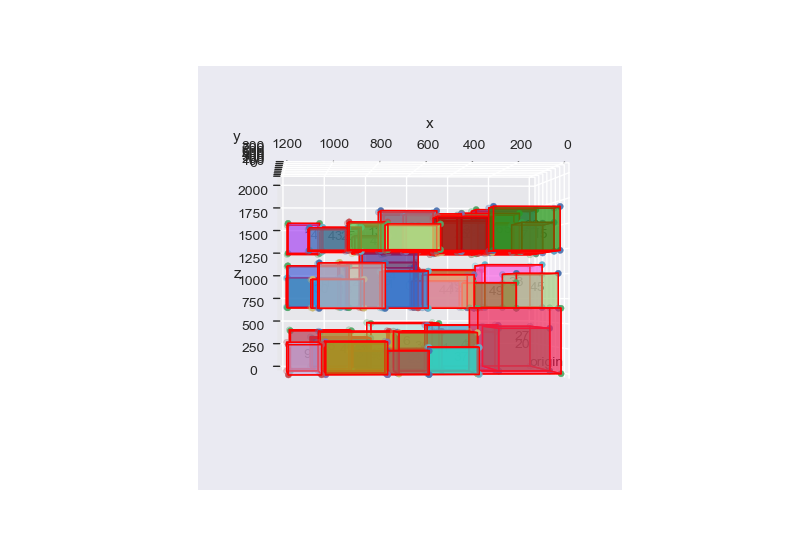

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [10]:
cg_bin_pool = bins.BinPool(cg_layer_pool, config.PALLET_DIMS)
cg_bin_pool.plot()

## Comparison

In [11]:
print("\tCG")
print("Bin Heights:", cg_bin_pool.get_heights())
print()
print("Bin Densities:", cg_bin_pool.get_bin_densities())
print()
print("Layer Densities:", cg_bin_pool.get_layer_densities(two_dims=False))
print()
print("\tMR")
print("Bin Heights:", mr_bin_pool.get_heights())
print()
print("Bin Densities:", mr_bin_pool.get_bin_densities())
print()
print("Layer Densities:", mr_layer_pool.get_densities(two_dims=False))

	CG
Bin Heights: [1715]

Bin Densities: [0.45399603862530413]

Layer Densities: [[0.5825106731014271, 0.5504133117816092, 0.48390885308385306]]

	MR
Bin Heights: [1840]

Bin Densities: [0.45399603862530413]

Layer Densities: [0.742000318877551, 0.5062176748294347, 0.41996953577336643, 0.40269961932976556]


<IPython.core.display.Javascript object>